In [1]:
import numpy as np
import pandas as pd

# Fix random seed for reproducibility
np.random.seed(123)

# CONFIG 
n_eligible = 500          # rows designed as low-income/eligible profile
n_ineligible = 300        # rows designed as high-income/ineligible profile
n_total = n_eligible + n_ineligible
fraud_fraction = 0.03     # 3% rows become fraud outliers

def choice(arr, size, p=None):
    """Simple wrapper around np.random.choice for readability."""
    return np.random.choice(arr, size=size, p=p)

# CREATE BASE DATAFRAME 
df = pd.DataFrame(index=range(n_total))

# DEMOGRAPHICS
df['Age'] = np.clip(np.random.normal(35, 12, size=n_total).round(), 18, 70)
df['Gender'] = choice(['Male', 'Female'], size=n_total, p=[0.55, 0.45])

marital_base = choice(['Single', 'Married', 'Divorced', 'Widowed'],
                      size=n_total, p=[0.4, 0.5, 0.07, 0.03])
df['Marital_Status'] = marital_base

# Younger citizens are mostly single
df.loc[df['Age'] < 25, 'Marital_Status'] = choice(
    ['Single', 'Married'],
    size=(df['Age'] < 25).sum(),
    p=[0.8, 0.2]
)

# Household size roughly around 3–5 members
df['Household_Size'] = np.clip(np.random.poisson(4, size=n_total), 1, 9)

df['Governorate'] = choice(['Muscat', 'Dhofar', 'Sohar', 'Nizwa', 'Sur'],
                           size=n_total, p=[0.35, 0.15, 0.2, 0.15, 0.15])

# ECONOMIC & HOUSEHOLD FINANCIALS
eligible_idx = np.arange(n_eligible)
ineligible_idx = np.arange(n_eligible, n_total)

salary = np.zeros(n_total)

# Salary for "eligible" profile: lower mean income
#salary[eligible_idx] = np.random.lognormal(mean=np.log(90), sigma=45, size=n_eligible)
salary[eligible_idx] = np.random.normal(90, 45, size=n_eligible)

# Salary for "ineligible" profile: higher mean income
#salary[eligible_idx] = np.random.lognormal(mean=np.log(1100), sigma=300, size=n_eligible)
salary[ineligible_idx] = np.random.normal(1100, 300, size=n_ineligible)

# Ensure no salary below 80 and round to 2 decimals
df['Salary'] = np.clip(salary, 80, None).round(2)

df['Degree_Level'] = choice(['None', 'HighSchool', 'Diploma', 'Bachelor', 'Master'],
                            size=n_total, p=[0.1, 0.35, 0.2, 0.3, 0.05])

df['Employment_Status'] = choice(['Employed', 'Unemployed', 'Student', 'Retired'],
                                 size=n_total, p=[0.6, 0.15, 0.15, 0.1])

# Ages 18–24: more students and unemployed
young_mask = df['Age'].between(18, 24)
df.loc[young_mask, 'Employment_Status'] = choice(
    ['Student', 'Unemployed', 'Employed'],
    size=young_mask.sum(),
    p=[0.6, 0.25, 0.15]
)

df['Primary_Income_Source'] = choice(['Government', 'Private', 'SelfEmployed', 'None'],
                                     size=n_total, p=[0.45, 0.3, 0.2, 0.05])

df['Has_Other_Social_Benefits'] = np.random.choice([0, 1], size=n_total, p=[0.7, 0.3])

# Assets: lower for eligible profile, higher for ineligible profile
#Initialize an empty array for Assets
assets = np.zeros(n_total)
assets[eligible_idx] = np.random.lognormal(mean=np.log(3000), sigma=0.5, size=n_eligible)
assets[ineligible_idx] = np.random.lognormal(mean=np.log(12000), sigma=0.6, size=n_ineligible)
df['Assets_Value'] = assets.round(2)

liabilities = np.random.lognormal(mean=np.log(2000), sigma=0.7, size=n_total)
df['Liabilities_Value'] = liabilities.round(2)

# Children: fewer for singles, more for married
# Base children for everyone
children = np.clip(np.random.poisson(2, size=n_total), 0, 7)

# Force Singles to have 0 children
children[df['Marital_Status'] == 'Single'] = 0

df['Number_of_Children'] = children


# Spouse income only for married citizens
# Spouse income only for married citizens
spouse_income = np.zeros(n_total)
married_mask = df['Marital_Status'] == 'Married'

# Lognormal distribution parameters
mean_log = np.log(250)   # median spouse income = 250
sigma_log = 0.45         # variation level (controls skew)

spouse_income[married_mask] = np.random.lognormal(
    mean=mean_log,
    sigma=sigma_log,
    size=married_mask.sum()
)

# Optional: clip extremely high values for realism
spouse_income = np.clip(spouse_income, 0, 2000)

df['Total_Spouse_Income'] = spouse_income.round(2)



# -------------------- CHILDREN INCOME (AGE-AWARE, SOME WORKING) --------------------

# Step 1: probability that a child in this household is working-age
# Older parents are more likely to have older (working) children.
# Base 0.10 + 1% per year above age 35, capped between 5% and 60%.
# -------------------- CHILDREN INCOME (AGE-AWARE, SOME WORKING) --------------------

# Base age-driven probability (we'll refine it by age bands)
base_p_work = 0.10 + 0.01 * (df['Age'] - 35)

# Start with zeros
p_work = np.zeros(len(df), dtype=float)
age = df['Age']

# Very young parents: effectively no working-age children
p_work[age < 30] = 0.00

# Young parents: very low chance
mask = (age >= 30) & (age < 35)
p_work[mask] = 0.02

# Mid-age parents: some teenage / young-adult children
mask = (age >= 35) & (age < 45)
p_work[mask] = np.clip(base_p_work[mask], 0.05, 0.20)

# Older parents: higher chance their children are working adults
mask = (age >= 45) & (age < 55)
p_work[mask] = np.clip(base_p_work[mask], 0.20, 0.40)

# Elderly parents: many children likely working
mask = (age >= 55)
p_work[mask] = np.clip(base_p_work[mask], 0.40, 0.60)


# --------- Number of working children per household (Binomial) ---------
working_children = []

for i, row in df[['Number_of_Children', 'Age']].iterrows():
    k = int(row['Number_of_Children'])
    if k == 0:
        # No children → no working children
        working_children.append(0)
    else:
        # Age-based probability for this household
        pw = p_work[i]          # already adjusted by age band
        # Binomial: out of k children, how many are working?
        wc = np.random.binomial(n=k, p=pw)
        working_children.append(wc)

df['Working_Children_Count'] = working_children


# --------- Step 2: income per working child (lognormal) ---------
child_income_per_worker = np.random.lognormal(
    mean=np.log(90),   # median ≈ 90 OMR
    sigma=0.5,
    size=n_total
)

# Total children income = working children * income per working child
df['Total_Children_Income'] = (
    df['Working_Children_Count'] * child_income_per_worker
).round(2)



# Total household income = salary + spouse income + children income
df['Total_Household_Income'] = (
    df['Salary'] + df['Total_Spouse_Income'] + df['Total_Children_Income']
).round(2)

# VEHICLE & CYLINDER-BASED FUEL MODEL 
# Vehicle ownership: all "eligible profile" rows must own a vehicle,
# ineligible rows: some own, some don't
veh_own = np.zeros(n_total, dtype=int)
veh_own[eligible_idx] = 1
veh_own[ineligible_idx] = np.random.choice([0, 1], size=n_ineligible, p=[0.4, 0.6])
df['Vehicle_Ownership'] = veh_own

# Vehicle count (for owners only)
veh_count = np.zeros(n_total, dtype=int)
veh_count[veh_own == 1] = np.random.choice(
    [1, 2, 3],
    size=(veh_own == 1).sum(),
    p=[0.7, 0.25, 0.05]
)
df['Vehicle_Count'] = veh_count

# NEW: Cylinder_Count instead of Vehicle_Type
# - 0 cylinders for non-owners
# - For owners: mostly 4-cylinder, some 6, few 8
cylinders = np.zeros(n_total, dtype=int)
owner_mask = df['Vehicle_Ownership'] == 1
cylinders[owner_mask] = np.random.choice(
    [4, 6, 8],
    size=owner_mask.sum(),
    p=[0.6, 0.3, 0.1]
)
df['Cylinder_Count'] = cylinders

# Vehicle age: only for owners; older cars consume slightly more
veh_age = np.zeros(n_total, dtype=int)
veh_age[owner_mask] = np.clip(
    np.random.normal(8, 4, size=owner_mask.sum()).round(),
    1, 20
)
df['Vehicle_Age_Years'] = veh_age

# Fuel type: Petrol vs Diesel (for owners)
df['Fuel_Type'] = np.where(
    df['Vehicle_Ownership'] == 0,
    'None',
    np.random.choice(['Petrol', 'Diesel'], size=n_total, p=[0.7, 0.3])
)

# ---- Expected Fuel Consumption (L/month) based on cylinders + age ----
# Base consumption by cylinder count (approximate typical monthly usage)
# You can tune these numbers if needed.
base_map = {
    0: 10,     # no vehicle: almost no fuel is assigned automatically when df['Vehicle_Ownership'] == 0
    4: 120,    # small car
    6: 180,    # mid-size / heavier
    8: 250     # large / powerful engine
}

# Compute base expected fuel from cylinder count
base_expected = np.array([base_map[c] for c in df['Cylinder_Count']])

# Age factor: older cars are slightly less efficient → consume more
# For example, +1% per year above 5, capped between 0.9x and 1.3x
age_factor = 1.0 + 0.01 * (df['Vehicle_Age_Years'] - 5)
#It means fuel consumption cannot go below 90% of the base value.
age_factor = np.clip(age_factor, 0.9, 1.3)

# Final expected consumption (for non-owners this stays small)
df['Expected_Fuel_Consumption_L'] = (base_expected * age_factor).round(2)

# ---- Actual Average Fuel Consumption ----
# Eligible profile: actual ≈ expected (normal behaviour)
fuel = df['Expected_Fuel_Consumption_L'].values.astype(float)
fuel[eligible_idx] *= np.random.normal(1.0, 0.10, size=n_eligible)

# Ineligible profile: slightly higher usage on average
fuel[ineligible_idx] *= np.random.normal(1.05, 0.15, size=n_ineligible)

# Clip at min 0
df['Average_Fuel_Consumption_L'] = np.clip(fuel, 0, None).round(2)

# Engineered fuel deviation features for fraud detection
df['Fuel_Deviation_L'] = (
    df['Average_Fuel_Consumption_L'] - df['Expected_Fuel_Consumption_L']
).round(2)

safe_expected = df['Expected_Fuel_Consumption_L'].replace(0, 1)
df['Fuel_Deviation_Ratio'] = (
    df['Average_Fuel_Consumption_L'] / safe_expected
).round(3)

# SUBSIDY BEHAVIOR HISTORY 
df['Previous_Subsidy_Received'] = np.random.choice([0, 1], size=n_total, p=[0.3, 0.7])

prev_amount = np.zeros(n_total)
mask_prev = df['Previous_Subsidy_Received'] == 1

prev_amount[mask_prev] = np.random.normal(25, 8, size=mask_prev.sum())
df['Previous_Subsidy_Amount'] = np.clip(prev_amount, 5, 60).round(2)

df['Late_or_Missed_Renewals'] = np.random.poisson(0.3, size=n_total)
df['Applications_Last_12_Months'] = np.random.poisson(1.0, size=n_total)

# FRAUD OUTLIERS
df['Fraud'] = 0
n_fraud = max(1, int(fraud_fraction * n_total))
fraud_idx = np.random.choice(df.index, size=n_fraud, replace=False)

# Fraud: abnormal high fuel usage + suspicious behaviour
df.loc[fraud_idx, 'Average_Fuel_Consumption_L'] *= 2.5
df.loc[fraud_idx, 'Applications_Last_12_Months'] += 3
df.loc[fraud_idx, 'Late_or_Missed_Renewals'] += 2

# Recompute deviations only for fraud rows
df.loc[fraud_idx, 'Fuel_Deviation_L'] = (
    df.loc[fraud_idx, 'Average_Fuel_Consumption_L'] -
    df.loc[fraud_idx, 'Expected_Fuel_Consumption_L']
).round(2)

safe_expected_fraud = df.loc[fraud_idx, 'Expected_Fuel_Consumption_L'].replace(0, 1)
df.loc[fraud_idx, 'Fuel_Deviation_Ratio'] = (
    df.loc[fraud_idx, 'Average_Fuel_Consumption_L'] / safe_expected_fraud
).round(3)

df.loc[fraud_idx, 'Fraud'] = 1

#  ELIGIBILITY LABEL 
# Main target: Eligible vs Ineligible

# Condition 1 – Financial need: low salary & low household income & owns car
cond1 = (
    (df['Salary'] <= 600) &
    (df['Total_Household_Income'] <= 900) &
    (df['Vehicle_Ownership'] == 1)
)

# Condition 2 – Married with dependents & owns car
cond2 = (
    (df['Marital_Status'] == 'Married') &
    (df['Number_of_Children'] >= 1) &
    (df['Vehicle_Ownership'] == 1)
)

# Condition 3 – Young (18–24), student/unemployed & owns car
cond3 = (
    (df['Age'].between(18, 24)) &
    (df['Employment_Status'].isin(['Student', 'Unemployed'])) &
    (df['Vehicle_Ownership'] == 1)
)

df['Eligible'] = (cond1 | cond2 | cond3).astype(int)

# Quick sanity check
print("Eligible:", df['Eligible'].sum(),
      "Ineligible:", len(df) - df['Eligible'].sum(),
      "Fraud:", df['Fraud'].sum())

# Save to CSV
df.to_csv("synthetic_subsidy_cylinders.csv", index=False)
print("Saved to synthetic_subsidy_cylinders.csv")




Eligible: 591 Ineligible: 209 Fraud: 24
Saved to synthetic_subsidy_cylinders.csv


PCA explained variance ratio: [0.23490659 0.12270418]


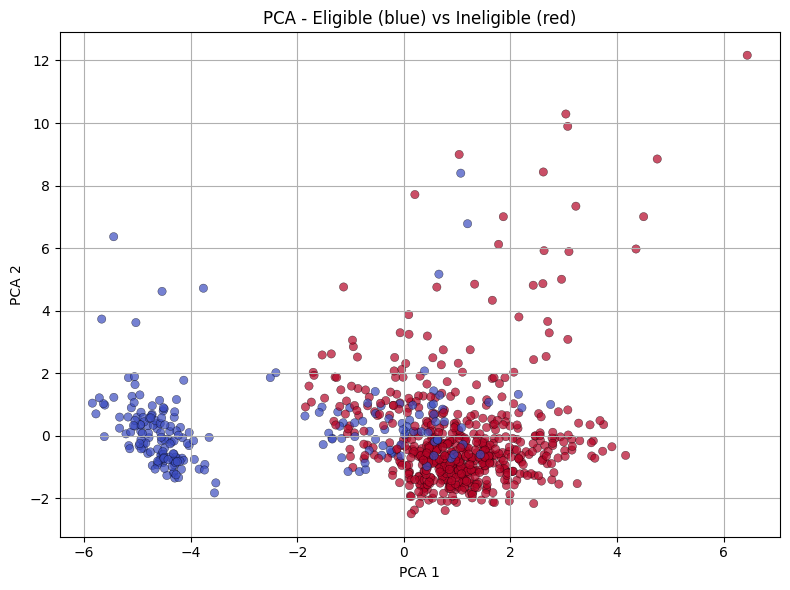

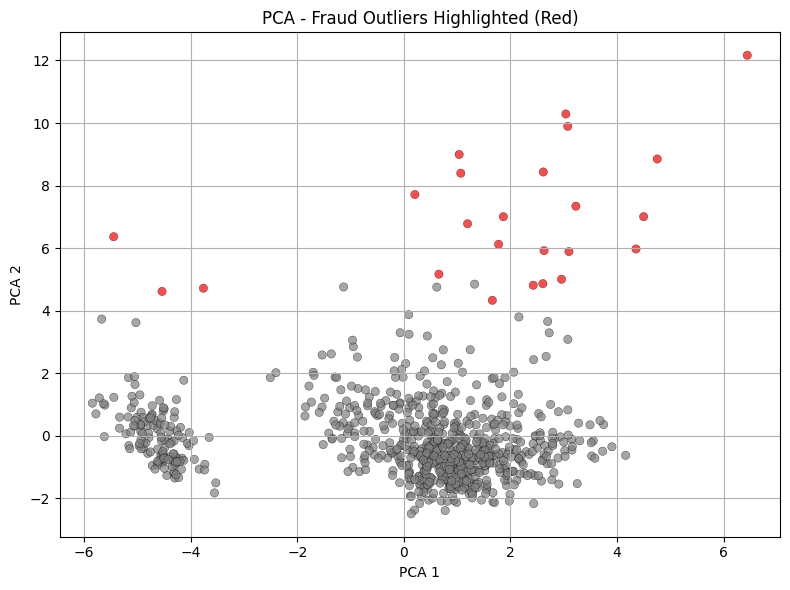

In [2]:
# In[47]:


import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# 1) Load the NEW dataset
df = pd.read_csv("synthetic_subsidy_cylinders.csv")

# 2) Use only numeric columns for embedding
numeric_df = df.select_dtypes(include=[np.number]).copy()

# Remove targets from features
X = numeric_df.drop(columns=["Eligible", "Fraud"])
y_eligible = df["Eligible"]
y_fraud = df["Fraud"]

# 3) Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PCA 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print("PCA explained variance ratio:", pca.explained_variance_ratio_)

# PCA: Eligible vs Ineligible
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=y_eligible, cmap="coolwarm", alpha=0.7,
            edgecolors="k", linewidths=0.3)
plt.title("PCA - Eligible (blue) vs Ineligible (red)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# PCA: Fraud outliers
plt.figure(figsize=(8,6))
colors = np.where(y_fraud == 1, "red", "grey")
plt.scatter(X_pca[:,0], X_pca[:,1],
            c=colors, alpha=0.7,
            edgecolors="k", linewidths=0.3)
plt.title("PCA - Fraud Outliers Highlighted (Red)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()



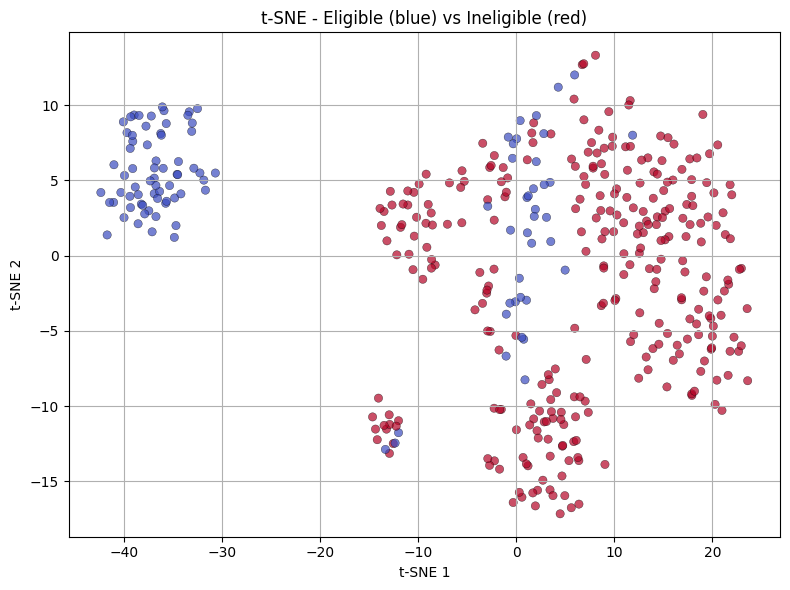

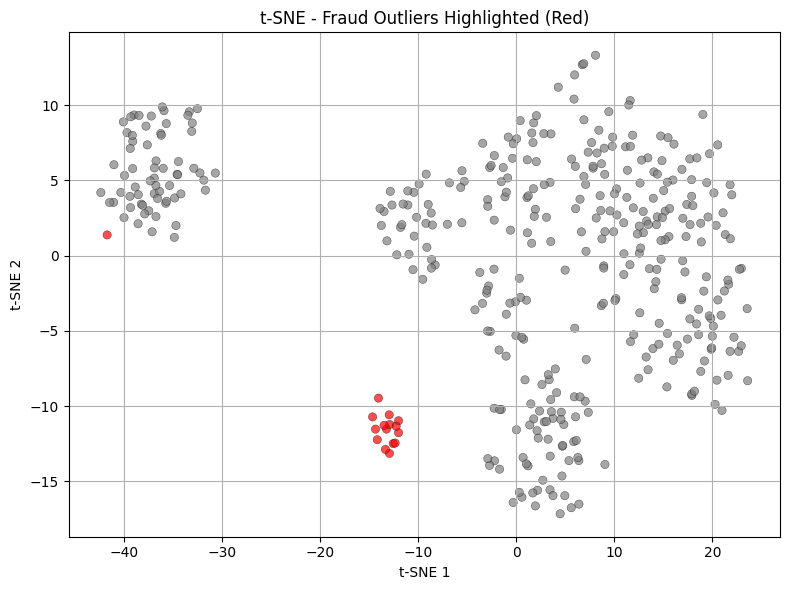

In [3]:
# t-SNE: Eligible vs Ineligible

# -t-SNE 
max_tsne_points = 400
if len(X_scaled) > max_tsne_points:
    idx = np.random.choice(len(X_scaled), size=max_tsne_points, replace=False)
    X_tsne_in = X_scaled[idx]
    y_elig_tsne = y_eligible.iloc[idx].values
    y_fraud_tsne = y_fraud.iloc[idx].values
else:
    X_tsne_in = X_scaled
    y_elig_tsne = y_eligible.values
    y_fraud_tsne = y_fraud.values

tsne = TSNE(n_components=2, init="pca", learning_rate="auto",
            perplexity=30, random_state=123)
X_tsne = tsne.fit_transform(X_tsne_in)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1],
            c=y_elig_tsne, cmap="coolwarm", alpha=0.7,
            edgecolors="k", linewidths=0.3)
plt.title("t-SNE - Eligible (blue) vs Ineligible (red)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# t-SNE: Fraud outliers
plt.figure(figsize=(8,6))
colors_tsne = np.where(y_fraud_tsne == 1, "red", "grey")
plt.scatter(X_tsne[:,0], X_tsne[:,1],
            c=colors_tsne, alpha=0.7,
            edgecolors="k", linewidths=0.3)
plt.title("t-SNE - Fraud Outliers Highlighted (Red)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.grid(True)
plt.tight_layout()
plt.show()
